### What is the CompEcon Toolbox?

* It is a MATLAB toolbox supporting Miranda and Fackler (2005): "Applied Computational Economics and Finance".


* The library functions include:
    * Rootfinding and optimization solvers
    * Function approximation using polynomials, splines and other functional families
    * Numerical integration

* [continued...]
    * Solvers for Ordinary Differential Equations
    * Routines solving discrete and continuous time dynamic programming problems
    * Solvers for financial derivatives


* The toolbox has been translated to **Julia** by Spencer Lyon.

### Interpolations Using CompEcon

* The CompEcon toolbox allows us to compute interpolations for:

    * Any number of dimensions
    * Any order of derivative and integral operators
    * Any order B-spline, Chebyshev polynomial, and piecewise linear basis functions
    * We can mix among different types of families across dimensions (i.e. Chebychev for x and splines for $\epsilon$)

### Structure of the Toolbox - Julia Version

* Think on 3 main "theoretical" categories:

    1. A functional `Basis`: Family of basis functions; Domain; Interpolation Nodes [see `basis.jl`].
    2. A `BasisStructure` representation: it evaluates the basis functions at the desired interpolation nodes [see `basis_structure.jl`].
    3. Coefficient vector: map from the domain of the `Basis` to the real line [obtained by solving linear system of equations].

* This general structure is going to become clearer once we go into an example model.


* This theoretical construct is mapped into **Julia** by defining groups of types


* See https://github.com/spencerlyon2/CompEcon.jl

### Group of Types

**Group 1:** types to represent the `Basis` in `Basis.jl`.
* `BasisFamily`: abstract type that defines the interpolant families.
```Julia
abstract BasisFamily
immutable Cheb <: BasisFamily end
immutable Lin <: BasisFamily end
immutable Spline <: BasisFamily end
```

* `BasisParams`: abstract type whose fields are all info needed to construct *univariate* basis.
```Julia
type ChebParams <: BasisParams
    n::Int
    a::Float64
    b::Float64
end
```

```Julia
type SplineParams <: BasisParams
    breaks::Vector{Float64}
    evennum::Int
    k::Int
end
```
```Julia
type LinParams <: BasisParams
    breaks::Vector{Float64}
    evennum::Int
end
```

* `Basis{N}`:
```Julia
type Basis{N, BF<:BasisFamily, BP<:BasisParams}
    basistype::Vector{BF}  # Basis family
    n::Vector{Int}         # number of points and/or basis functions
    a::Vector{Float64}     # lower bound of domain
    b::Vector{Float64}     # upper bound of domain
    params::Vector{BP}     # params to construct basis
end
```

* Finally note that inside this file there are two additional useful functions:

    1. `nodes`: given the chosen `Basis`, it computes the nodes.
    2. `Basis`: used to define the basis and also to create multidimensional basis.
   

**Group 2:** type to represent the `BasisStructure` in `basis_structure.jl`.

* `AbstractBasisStructureRep` [`ABSR`]: it groups the types of representation (Tensor, Direct, Expanded).


* An important function is `BasisStructure`.

    * Its inputs are the `basis`, the type of representation (Tensor, etc) and the nodes.
    * Its output is the interpolant valued at the nodes, $\Phi$ (Matrix).

* Another interesting function is `Base.convert` which converts from a `Tensor` or `Direct` `BasisStructure` to an `Expanded` one.

* For example, the following will convert from direct to expanded.
```Julia
Φ_direct = BasisStructure(basis, CompEcon.Direct(),snodes,0)
Φ = convert(Expanded, Φ_direct, [0 0]).vals[1]
```


* In the end we will need the expanded version, but the other two are more efficient in terms of storage.

## Quick Example (Same as Spencer's GitHub)

### One Dimension:
Approximate  $f(x)=e^{-x}$ on $x\in[-1,1]$ using the three types of interpolations.

For a known univariate function $f(x)$ there are 3 ways to approximate it. I will do the three of them, but changing the basis type (Cheb and Splines).

```Julia
using CompEcon
f(x) = exp(-x)
a,b = -1.0,1.0
```
*** Option 1: Using `funfitf`***
```Julia
n = 10
basis_c = Basis(Cheb, n, a, b)
c_c = funfitf(basis_c, f)
```

*** Option 2: Using `funfitxy`***
```Julia
xgrid = collect(linspace(a,b,n))
basis_s = Basis(Spline, xgrid, 0, 1)
x_s = nodes(basis_s)[1]
y_s = f(x_s)
c_s = funfitxy(basis_s, x_s, y_s)[1]
```

*** Option 3: Using `BasisStructure`***
```Julia
x_c = nodes(basis_c)[1]
y_c = f(x_c)
phi_c = BasisStructure(basis_c).vals[1]
c_c2 = phi_c\y_c
```

In [ ]:
using CompEcon
f(x) = exp(-x)

# Set the endpoints of approximation interval:
a =  -1.0                            # left endpoint
b =   1.0                            # right endpoint
n = 10                             # order of approximation

In [ ]:
# Option 1: (with Cheb)
basis_c = Basis(Cheb, n, a, b)
c_c = funfitf(basis_c, f)

# Option 2: (with Spline)
xgrid = collect(linspace(a,b,n))
basis_s = Basis(Spline, xgrid, 0, 1)
x_s = nodes(basis_s)[1]
y_s = f(x_s)
c_s = funfitxy(basis_s, x_s, y_s)[1]

In [ ]:
# Option 3: (with Cheb again)
x_c = nodes(basis_c)[1]
y_c = f(x_c)
phi_c = BasisStructure(basis_c, CompEcon.Expanded(),x_c).vals[1]
c_c2 = phi_c\y_c


# Compare different approaches
print("Coefficients from options 1 and 3")
[c_c c_c2]

In [ ]:
# Having computed the basis coefficients, one may now evaluate the
# approximant at any point x using funeval:
xvals = collect(linspace(-1.0,1.0,50))
y_c = funeval(c_c, basis_c, xvals)
y_s = funeval(c_s, basis_s, xvals)
yy = f(xvals)

yvals = [y_c y_s yy]

Method = ["Cheb", "Spline", "True Function"]

using PyPlot
fig, ax = subplots()
for i=1:3
    meth = Method[i]
    ax[:plot](xvals, yvals[:,i], linewidth=2, alpha=0.6, label=L"$Method$ ="" $meth")
end
ax[:legend](loc=1)

### Two Dimensions:

Let the "state" be given by $s=(a,y)$. I take the function $f(s) = \sqrt{a}\exp{(y)}$. To generate the interpolation, I use a linear spline for the first variable and a Chebichev polynomial for the second. Then I plot the true value and the interpolation, for different values of $s$.

In this example, we get a better approximation by mixing splines and Chebychev, than by just using Chebychev in both arguments.

In [ ]:
fun2(st) = sqrt(st[:,1]).*exp(st[:,2])

agrid0 = collect(linspace(0.0,10.0,10))

a_basis = Basis(Spline, agrid0, 0, 1)
y_basis = Basis(Cheb, 10, 0.0, 10.0)
basis2 = Basis(a_basis, y_basis)

c_2d = funfitf(basis2, fun2)

In [ ]:
avals  = collect(linspace(0.0,10.0,50))
yvals  = collect(linspace(0.0,10.0,50))
svals  = [avals yvals]
y_val  = funeval(c_2d, basis2, svals)
y_true = fun2(svals)

yvals2d = [y_val y_true]

In [ ]:
Method = ["Interpolation", "True Function"]

using PyPlot

fig, ax = subplots()
for i=1:2
    meth = Method[i]
    ax[:plot](1:1:50, yvals2d[:,i], linewidth=2, alpha=0.6, label=L"$Method$ ="" $meth")
end
ax[:legend](loc=1)

### Baseline Model: Economic Growth

* Consider an economy that produces and consumes a single composite good.
* Infinite horizon. Continuous state and action.
* At the begining of period $t$ it has $s\in(0,\infty)$ units, of which invests $x\in[0,s)$.
* State transition function: $s=g(s,x,\epsilon)=\gamma x+\epsilon f(x)$.

* Rewards function:
\begin{equation}
F(s,x)=u(s-x)=\frac{(s-x)^{1-\alpha}}{1-\alpha}
\end{equation}
* Bellman Equation:
\begin{equation}
V\left(\left[x,\epsilon\right]\right)=\max_{0\leq x'\leq s=g\left(x,\epsilon\right)}\left\{u\left(g\left(x,\epsilon\right)-x'\right)+\delta E_{\epsilon'}V\left(\left[x',\epsilon'\right]\right)\right\}
\end{equation}
* Assume $u'(0)=-\infty$ and $h(0)=0$

* From FOC, we get the Euler equation:
\begin{equation}
u_{t}'=\delta E_{t}\left[u_{t+1}'\left(\gamma+\epsilon_{t+1}f_{t}'\right)\right]
\end{equation}
* Steady State ($\epsilon=1$):
    * $u'\left(s^{*}-x^{*}\right)=\delta\lambda^{*}\left[\gamma+f'\left(x^{*}\right)\right]$
    * $\lambda^{*}=u'\left(s^{*}-x^{*}\right)$
    * $s^{*}=\gamma x^{*}+f\left(x^{*}\right)$
    
    
* CE SS conditions imply the golden rule $1-\gamma+r=f'(x^{*})$ where $\delta=1/(1+r)$

To approximate the solution, I follow Simon Mongey's notes given during Gianlucca Violante's course.
   
   * Define the set of collocation nodes $s = [\mathbf{1}_{Nz}\otimes{}\mathbf{X},\mathbf{Z}\otimes{}\mathbf{1}_{Nx}]$ and let $N=N_{x}\text{x}N_{z}$
   
   * We can define the following system:
   \begin{equation}
   V(s_{i}) = \max_{x'\in B(s_{i})}F(s_{i},x')+\beta V_{e}([x',s_{i,2}]) \\
   V_{e}(s_{i}) = \sum_{k=1}^{Nz}P(z,z_{k}')V([s_{i,1},z'_{k}])
   \end{equation}

   * If we substitute for the interpolants:
   
   \begin{equation}
   \sum_{j=1}^{N}\phi(s_{i})c_{j}= \max_{x'\in B(s_{i})}F(s_{i},x')+\beta\sum_{j=1}^{N}\phi([x',s_{i,2}])c_{j}^{e} \\
   \sum_{j=1}^{N}\phi(s_{i})c_{j}^{e}= \sum_{k=1}^{Nz}P(z,z_{k}')\sum_{j=1}^{N}\phi([s_{i,1},z'_{k}])c_{j}
   \end{equation}

   * ... and write it in a stacked form, we get:
   
     \begin{equation}
   \Phi(s) = \max_{x'\in\mathbf{B}(s)}F(s,x')+\beta\Phi([x',s_{2}])c^{e} \\
   \Phi(s)c^{e} = (P\otimes{}\mathbf{I}_{Nx})\Phi(s)c
   \end{equation}
   
   
   * Note: recall $\Phi([a,b,c])=\Phi_{a}\Phi_{b}\Phi_{c}$. It is going to be useful later, and it is associated to the `Direct` specification.
   
   
   * The following scripts solves this model using Julia's version of CompEcon written by Spencer Lyon.

* In the following first block I define the Economic Growth model type EconGrowth and auxiliary functions. Some of them are going to be part of the EconGrowth model, since are intrinsic to this specific model.


* In particular, these functions are the utility function, the production function and the law of motion for wealth.
The auxiliary functions are for the discretization of the stochastic process and the definition of the basis.

In [36]:
using CompEcon

# Step 0: Define the Economic Growth model type EconGrowth

type EconGrowth
    a::Float64
    b::Float64
    nx::Int64
    m::Int64
    σ::Float64
    δ::Float64
    α::Float64
    β::Float64
    γ::Float64
    basis::Basis
    bs::BasisStructure
    Φ::SparseMatrixCSC{Float64,Int}
    snodes::Matrix{Float64}
    ϵ::Vector{Float64}
    P::Matrix{Float64}
    tol::Float64 # Tolerance Level.
    maxit::Int # Maximum iterations.
end

# Step 1: Define the model's functions
f(eg::EconGrowth, x) = x.^eg.β
g(eg::EconGrowth, sn=eg.snodes) = eg.γ*sn[:,1] + sn[:,2].*f(eg, sn[:,1])
u(eg::EconGrowth, sn, xprime) = (g(eg, sn)-xprime).^(1-eg.α)./(1-eg.α)


# Step 2: Discretize stochastic process and build interpolation basis.
# Wrap up everything in the EconGrowth function.

function EconGrowth(;a::Float64=2.0,
                     b::Float64=8.0,
                     nx::Int64=10,
                     m::Int64=3,
                     σ::Float64=0.1,
                     δ::Float64=0.9,
                     α::Float64=2.0,
                     β::Float64=0.5,
                     γ::Float64=0.9,
                     tol::Float64=1e-9,
                     maxit::Int=10_000)
    
    # Discretize stochastic process
    ϵ, ω = qnwlogn(m, 0, σ^2) # quadrature for lognormal
    P = repmat(ω', m, 1) # Since the process is i.i.d but I wanted to keep the general structure.

    # Build interpolation basis
#     x_params = SplineParams(nx, a, b, 1)
    x_params = ChebParams(nx, a, b)
    z_params = LinParams(ϵ, 0)
    basis = Basis(x_params, z_params)
    snodes, (xnodes, znodes) = nodes(basis)
    bs = BasisStructure(basis, Direct(), snodes, [0 0])
    Φ = convert(Expanded, bs).vals[1]

    EconGrowth(a, b, nx, m, σ, δ, α, β, γ, basis, bs, Φ, snodes, ϵ, P, tol, maxit)
end


# Step 3: Compute the Steady State

function steady_state(eg::EconGrowth)
    δ, γ, β, α = eg.δ, eg.γ, eg.β, eg.α

    r_ss = 1/δ-1
    x_ss = ((1/β)*(1/δ-γ))^(1/(β-1))
    s_ss = γ*x_ss+x_ss^β
    c_ss = s_ss-x_ss
    lambda_ss = (c_ss)^(-α)
    vals_ss = [r_ss,x_ss,s_ss,c_ss,lambda_ss]
end

steady_state (generic function with 1 method)

* Next I write down:
    * the optimization problem
    * the one-setp update function
    * and the iteration function
    
    
* For the optimization I choose the CompEcon Golden Method search algorithm. Alternativley I could use a Newton-Rhapson method.


* For solving the Bellman Equation using the collocation nodes I just iterate. Alternatively I could use some Newton rootfinding algorithm.

In [37]:
# Step 4: Write the Optimization Problem
function obj_fun(eg::EconGrowth, ce::Array{Float64,1})

    function obj(xp)
        Φ_xp = BasisStructure(eg.basis[1], Expanded(), xp, [0]).vals[1]
        Φ = row_kron(eg.bs.vals[2], Φ_xp)
        u(eg, eg.snodes, xp) + eg.δ*Φ*ce
    end

    x_sol,f_sol = golden_method(obj, zeros(size(eg.snodes, 1)), g(eg, eg.snodes))

end


# Step 5: Write down the iterative procedure (one-step)
# Bellman Iteration

function one_step(eg::EconGrowth, cc::Vector{Float64}, ce::Vector{Float64}, P_Φ)
    xsol,fsol = obj_fun(eg, ce)
    f2 = P_Φ*cc

    cc_out = eg.Φ\fsol
    ce_out = eg.Φ\f2

    return cc_out, ce_out
end


one_step (generic function with 1 method)

In [38]:
# Step 6: Define the iteration function
function iter(eg::EconGrowth)
    iteration = 0
    di = 1

    n_x = length(nodes(eg.basis.params[1]))
    P_Φ = kron(eg.P, eye(n_x))*eg.Φ

    cc = zeros(size(eg.snodes, 1))
    ce = zeros(size(eg.snodes, 1))

    while di>eg.tol
        iteration += 1
            if iteration > eg.maxit
                break
            else
                cc0 = copy(cc)
                ce0 = copy(ce)
                cc,ce = one_step(eg, cc0, ce0, P_Φ)

                resid1 = norm(cc0-cc)
                resid2 = norm(ce0-ce)

                di = max(resid1,resid2)
#             @printf("Iteration %d with distance %.3f\n", iteration, di)
            end
    end

    @printf("The total number of interations was %d.\n", iteration)

    return cc, ce
end


iter (generic function with 1 method)

* Finally I give values to the parameters and use it for input to the EconGrowth type.
* With that I can solve the model, given this set of parameters.
* Then I plot investment (x) in percentage to wealth (s).

In [39]:
# Computation of the Steady State
eg = EconGrowth()
vals_ss = steady_state(eg)

@printf("The steady values are r = %.2f, x = %.2f, s = %.2f, c = %.2f.\n"
,vals_ss[1],vals_ss[2],vals_ss[3],vals_ss[4])

# Solution to the Model
cc, ce = iter(eg)

println("The vector of coefficients cc and ce are:\n $([cc ce])")

The steady values are r = 0.11, x = 5.61, s = 7.42, c = 1.81.
The total number of interations was 399.
The vector of coefficients cc and ce are:
 [-6.148872886307476 -6.002342157669572
 1.4293903189819739 1.365007974315387
 -0.30242864651737383 -0.2855586913738552
 0.07582912444092763 0.07110552708156898
 -0.020564340751041812 -0.01916857818324296
 0.0058327865049471695 0.0054283140816016135
 -0.0016939025683300657 -0.0015642406293160244
 0.0005136389136879392 0.00047047470848094803
 -0.00016134840315931573 -0.0001479459366909434
 3.90311738541416e-5 4.683426777777204e-5
 -6.004497336230142 -6.002342157669572
 1.365443212024492 1.3650079743153873
 -0.2856095706000894 -0.28555869137385514
 0.07109143135780838 0.07110552708156898
 -0.019172654228205393 -0.019168578183242573
 0.00542009565553203 0.005428314081601409
 -0.0015684885484015725 -0.0015642406293160285
 0.00046658723147479606 0.00047047470848118135
 -0.00015266865654640967 -0.0001479459366911911
 4.653069839357178e-5 4.683426777

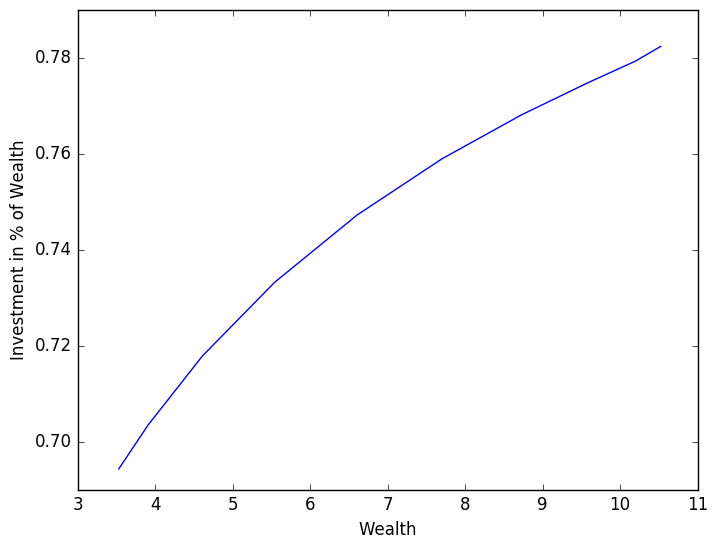

(PyObject <matplotlib.text.Text object at 0x31dde7450>,PyObject <matplotlib.text.Text object at 0x31de16590>)

In [49]:
using PyPlot

xsol,fsol = obj_fun(eg,ce)

s = g(eg,eg.snodes)

yplot = (xsol)./s

plot(s[2*eg.nx+1:3*eg.nx],yplot[2*eg.nx+1:3*eg.nx])
xlabel("Wealth"), ylabel("Investment in % of Wealth")
